In [1]:
import jax, tqdm
import jax.numpy as jnp
import numpy as np

from jax import grad, value_and_grad
from jax.nn import softmax, log_softmax

from numpyro.optim import Adam

from functools import partial

np.random.seed(123)
np.set_printoptions(suppress=True)

/home/jalko/.conda/envs/waltti/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to minimize the probability of returning a wrong category under the DP guarantee. We do this by learning utility scores for the exponential mechanism. We also want to minimize the probability of releasing categories that are far from the truth. For the latter, we penalise the loss function with an distance penalty.

In [2]:
lamb = 0.001 # weight for l2 penalty
bandwidth = 0.1 # kernel bandwidth


def get_logps(qs, eps):
    n = len(qs)
    sensitivity = jnp.max(jnp.abs(qs[:(n-1)]-qs[1:]))

    log_ps = log_softmax(eps / (2.*sensitivity) * qs, axis=1)
    return log_ps

#cat_edges = [5, 40, 50, 65, 72, 78] # NOTE
def loss(qs, categories, eps):
    n_cats = categories.shape[1]
    distances = np.abs(np.arange(0,n_cats).reshape(-1, 1) - np.arange(0,n_cats).reshape(1, -1))
    kernel = np.exp(-distances / bandwidth)
    logps = get_logps(qs, eps)
    
    bce = -1. * jnp.sum(logps * categories) # we want to maximize prob. of releasing the correct label
    distance_penalty = 0.5 * jnp.sum(logps *  (categories @ kernel)) # we want to minimize prob. of releasing 'far away' categories
    l2_penalty = lamb * jnp.linalg.norm(qs) # we want to keep the utility scores reasonable to avoid numerical issues
    return bce + distance_penalty + l2_penalty

## Setting the data

Now replicate the setting described in the [Problem statement](https://github.com/tvv-lippu-ja-maksujarjestelma-oy/waltti-apc-anonymization-plan/blob/main/README.md)

In [3]:
n_seats = 78
# n_cats = 5
# cat_edges = [(i+1) * int(n_seats // n_cats) for i in range(n_cats)]
# cat_edges[-1] = n_seats
n_cats = 6
cat_edges = [5, 40, 50, 65, 72, 78]
print(cat_edges)
categories = np.empty((n_seats+1, n_cats))
j = 0
for i in range(n_seats+1):
    if i > cat_edges[j]:
        j += 1
    categories[i] = np.eye(n_cats)[j]
print(np.sum(categories, axis=0))

[5, 40, 50, 65, 72, 78]
[ 6. 35. 10. 15.  7.  6.]


## Training

Now, lets train the model

In [4]:
eps = .1
init_qs = jnp.array(np.random.randn(n_seats+1, n_cats) * 0.1)

learning_rate = 1e-3
optimizer = Adam(learning_rate)

def update_epoch(i, params):
    optim_state, last_chunk_loss = params
    qs = optimizer.get_params(optim_state)
    loss_at_iter, grads = value_and_grad(partial(loss, categories=categories, eps=eps))(qs) 
    optim_state = optimizer.update(grads, optim_state)
    return optim_state, loss_at_iter

from jax.lax import fori_loop

T = 1000000
epoch_len = 10000 # this is essentially a chunk size. We split the learning into chucks to get some progress prints
optim_state = optimizer.init(init_qs)

print(f"Initial loss: {loss(optimizer.get_params(optim_state), categories, 1.0)}")

progresss_bar = tqdm.tqdm(range(T // epoch_len))

for epoch_nr in progresss_bar:
    optim_state_new, loss_at_iter = fori_loop(0, epoch_len, update_epoch, (optim_state, 0.0))
    progresss_bar.set_description(f"Loss {loss_at_iter.item():.2f}")
    if jnp.isnan(loss_at_iter):
        print("Nans!!!!!")
        break
    optim_state = optim_state_new
    
qs = optimizer.get_params(optim_state)
ps = jnp.exp(get_logps(qs, eps))

Initial loss: 70.8302230834961


Loss 33.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.04it/s]


## Results

Next, lets illustrate what the learned probabilities look like. We will do show, by plotting the probs in a heatmap, where the rows correspond to the headcounts and columns to the categories

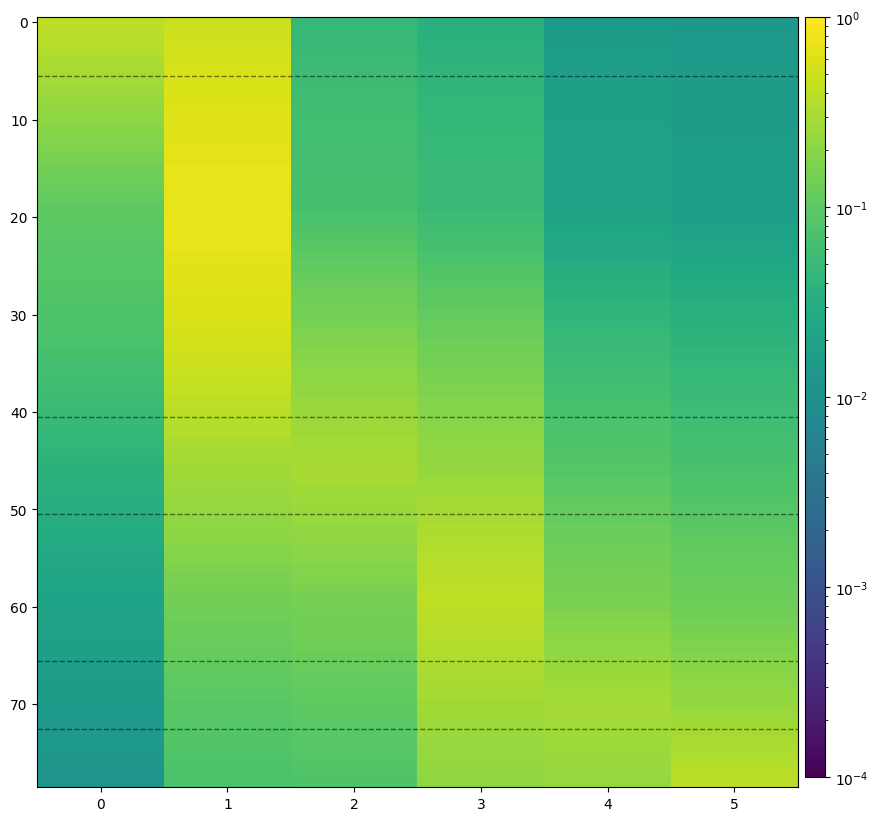

In [5]:
import matplotlib.pyplot as plt

plt.close()

fig, axis = plt.subplots(figsize=(10,10))

#im = axis.imshow(ps, aspect=n_cats / n_seats)
im = axis.imshow(ps, aspect=n_cats / n_seats, vmin=1e-4, vmax=1., norm='log')
for edge in cat_edges[:-1]:
    axis.axhline(edge+0.5, color='k', lw=1, ls="--", alpha=0.5)
cbar_ax = fig.add_axes([0.9, 0.12, 0.02, 0.76])
fig.colorbar(im, cax=cbar_ax)
fig.savefig("probs_matrix_em.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [6]:
ps[72]

DeviceArray([0.01452   , 0.08845571, 0.09525441, 0.25768292, 0.27646893,
             0.26761806], dtype=float32)

### Empirical check for DPness

Now as we have trained the utility scores, we can varify that the learned solution is DP. 
For $\epsilon$-DP, we of course require 
\begin{align}
    | \log \Pr(M(C+1) = i) - \log \Pr(M(C) = i) | \leq \epsilon,
\end{align}
for counts $C$ and $C+1$ produced by neighbouring data sets. We can verify this now simply by comparing the learned log-probabilities between concecutive counts.

In [7]:
logps = get_logps(qs, eps)
max_abs_logdiff_for_count = np.max(np.array([np.abs(logps[i] - logps[i+1]) for i in range(0, n_seats)]), axis=1)
print(max_abs_logdiff_for_count)
print(max_abs_logdiff_for_count.max())
print(np.max(max_abs_logdiff_for_count) < eps)

[0.0536167  0.05990911 0.06123805 0.06229234 0.06323862 0.06814301
 0.06620884 0.07315612 0.07295191 0.07356679 0.07529306 0.07621193
 0.07825935 0.07973576 0.08048689 0.08200431 0.07677078 0.08394885
 0.08458352 0.04770589 0.07472849 0.0747273  0.07681394 0.07657313
 0.07466245 0.07137513 0.07028437 0.06852627 0.0674572  0.06399822
 0.06162012 0.06198394 0.05851102 0.05598199 0.05377829 0.05256295
 0.05000663 0.04738379 0.05012041 0.05294192 0.05581069 0.05761123
 0.05874896 0.06202531 0.06445193 0.04822516 0.05690837 0.05527949
 0.05211902 0.05048919 0.04883599 0.05030334 0.05255723 0.05543423
 0.05628276 0.05895305 0.06051779 0.06138349 0.06443727 0.06697893
 0.06483507 0.06243658 0.06192505 0.05970657 0.05768716 0.05553567
 0.0538373  0.05171037 0.04945171 0.04780746 0.07136607 0.06773555
 0.06746566 0.06732905 0.06431043 0.06130278 0.05748308 0.05339992]
0.08458352
True


In [8]:
print(max_abs_logdiff_for_count.mean())

0.062769726


In [8]:
(np.exp(logps) * categories).sum(1).min()

0.23737789690494537

## Permute and flip

In [9]:
sensitivity = jnp.max(jnp.abs(qs[:((n_seats+1)-1)]-qs[1:]))

def permute_and_flip(q, eps):
    q_star = np.max(q)
    rs = np.random.permutation(np.arange(len(q)))
    for r in rs:
        pr = np.exp(eps / (2 * sensitivity)*(q[r] - q_star))
        if np.random.rand()<pr:
            return r    

### Test at the edge

Lets compare the permute and flip and EM for reporting the count $6$, which is on the edge of two bins.

In [10]:
indx = 5

In [11]:
releases_pf_for_indx = np.array([permute_and_flip(qs[indx], eps) for i in range(10000)])

In [12]:
cats, counts_pf = np.unique(releases_pf_for_indx, return_counts=True)
freqs_pf = counts_pf / counts_pf.sum()
for cat, freq in zip(cats, freqs_pf):
    print(cat, freq)

0 0.2474
1 0.6705
2 0.0326
3 0.0272
4 0.0126
5 0.0097


In [13]:
probs_em_for_indx = np.exp(get_logps(qs, eps)[indx])
for cat, freq in zip(np.arange(probs_em_for_indx.shape[0]), probs_em_for_indx):
    print(cat, freq)

0 0.30119655
1 0.57048196
2 0.054689053
3 0.0409938
4 0.017476287
5 0.015162427
